C:\Users\ajith\AppData\Local\Temp\ipykernel_16272\2110456536.py:25: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  data = pickle.load(f, encoding='latin1')


Epoch 1/10
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.6490 - loss: 0.9226 - val_accuracy: 0.6373 - val_loss: 0.8640
Epoch 2/10
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.7182 - loss: 0.7196 - val_accuracy: 0.7198 - val_loss: 0.7537
Epoch 3/10
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.7456 - loss: 0.6575 - val_accuracy: 0.7753 - val_loss: 0.5913
Epoch 4/10
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.7577 - loss: 0.6260 - val_accuracy: 0.6922 - val_loss: 0.7561
Epoch 5/10
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.7628 - loss: 0.6091 - val_accuracy: 0.7572 - val_loss: 0.6076
Epoch 6/10
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.7716 - loss: 0.5921 - val_accuracy: 0.7815 - val_loss: 0.6496
Epoch 7/10
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.7759 - loss: 0.5764 - val_accuracy: 0.7902 - val_loss: 0.5528
Epoch 8/10
1276/1276 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.7823 -

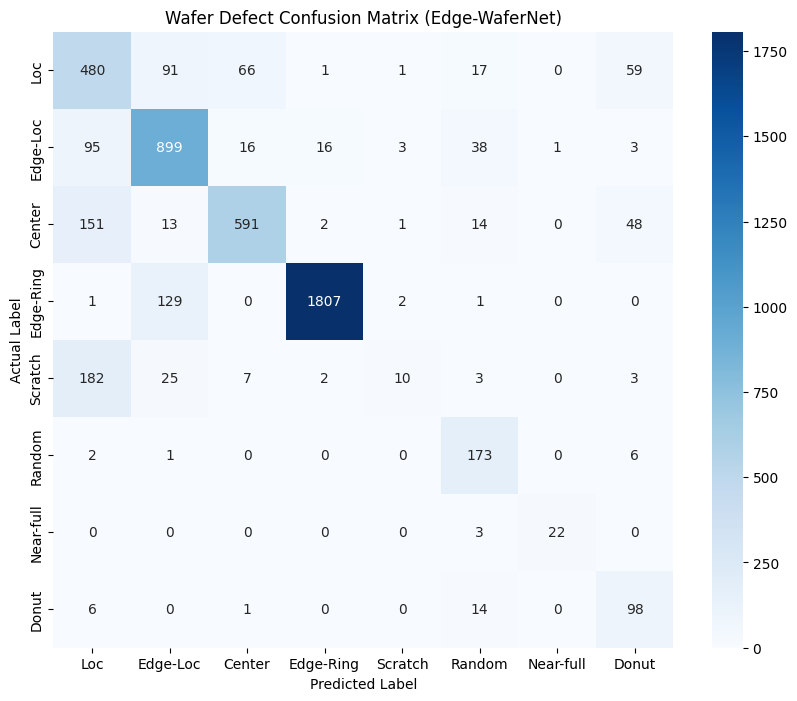

INFO:tensorflow:Assets written to: C:\Users\ajith\AppData\Local\Temp\tmpf3fzksgs\assets


INFO:tensorflow:Assets written to: C:\Users\ajith\AppData\Local\Temp\tmpf3fzksgs\assets


Saved artifact at 'C:\Users\ajith\AppData\Local\Temp\tmpf3fzksgs'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='keras_tensor_10')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  2530376654800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2530376655376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2530376654992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2530376656720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2530376657296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2530376657104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2530376656528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2530376656144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2530376657680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2530376656336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2530

In [2]:
import sys
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from scipy import ndimage
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# ==========================================
# 1. LEGACY COMPATIBILITY & DATA LOADING
# ==========================================
import pandas.core.indexes as indexes
sys.modules['pandas.indexes'] = indexes

def load_and_preprocess():
    file_path = 'LSWMD.pkl'
    
    if os.path.exists(file_path):
        with open(file_path, 'rb') as f:
            data = pickle.load(f, encoding='latin1')
        df = pd.DataFrame(data)
        
        df['failureType'] = df['failureType'].apply(
            lambda x: x[0][0] if isinstance(x, (list, np.ndarray)) and len(x) > 0 else 'none'
        )
        df_defects = df[df['failureType'] != 'none'].copy()
    else:
        # Fallback for verification
        test_data = {
            'waferMap': [np.random.randint(0, 3, (26, 26)) for _ in range(500)],
            'failureType': [np.random.choice(['Center', 'Donut', 'Scratch', 'Edge-Loc']) for _ in range(500)]
        }
        df_defects = pd.DataFrame(test_data)

    # Label Mapping
    class_names = df_defects['failureType'].unique()
    label_map = {val: i for i, val in enumerate(class_names)}
    df_defects['label_id'] = df_defects['failureType'].map(label_map)
    
    processed_images = []
    for x in df_defects['waferMap']:
        denoised = ndimage.median_filter(x, size=2)
        resized = tf.image.resize(denoised[:, :, np.newaxis], (28, 28)).numpy()
        processed_images.append(resized)
    
    X = np.array(processed_images).astype('float32') / 2.0
    y = tf.keras.utils.to_categorical(df_defects['label_id'])
    
    return X, y, class_names

# Run Pipeline
X, y, class_names = load_and_preprocess()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ==========================================
# 2. EDGE-OPTIMIZED ARCHITECTURE
# ==========================================
def build_precision_model(num_classes):
    model = models.Sequential([
        layers.Input(shape=(28, 28, 1)),
        layers.SeparableConv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.SeparableConv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(), 
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2), 
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = build_precision_model(len(class_names))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ==========================================
# 3. TRAINING
# ==========================================
history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# ==========================================
# 4. RESEARCH EVALUATION (Confusion Matrix & Report)
# ==========================================
print("\n--- Model Evaluation Report ---")

# 4a. Generate Predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# 4b. Print Classification Report
# This shows Precision, Recall, and F1-Score for every defect type
print(classification_report(y_true, y_pred, target_names=class_names))

# 4c. Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Wafer Defect Confusion Matrix (Edge-WaferNet)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# ==========================================
# 5. NXP eIQ EXPORT
# ==========================================
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open('wafer_defect_edge.tflite', 'wb') as f:
    f.write(tflite_model)

print("\n🚀 SUCCESS: Full metrics generated and .tflite model saved.")